# Importing features and building a baseline model

In the previous notebook, we read and cleaned the [Helen district heat generation dataset](https://www.helen.fi/helen-oy/vastuullisuus/ajankohtaista/avoindata).

Now, we will import some weather data from Finnish Metheorological Institute (FMI) and augment the DH data.

We will build a baseline model, against which all future experiments will be compared.
The baseline model will be a regression model, with outside temperature as the only predicting variable.
Most likely the ambient temperature will be the most important factor in the end, accounting to a large share of the total variable.

In [1]:
# Add parent folder to path, so that we can import local dh_modelling Python module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
from matplotlib.pyplot import Figure
from pathlib import Path

from dh_modelling.prepare import FmiData, GenerationData, merge_dataframes, train_test_split_sorted

## Data processing and importing

Data importing is now defined in accompanying Python module.
Let's inspect the methdods a bit.

In [2]:
def page_printer(data, start=0, screen_lines=0, pager_cmd=None):
    if isinstance(data, dict):
        data = data['text/plain']
    print(data)

import IPython.core.page
IPython.core.page.page = page_printer

??GenerationData.load_and_clean

Signature: GenerationData.load_and_clean(self) -> 'DataFrame'
Source:   
    def load_and_clean(self) -> DataFrame:
        """
        Load dataframe from disk, clean up features

        :return: Pandas dataframe, with index column 'date_time' and feature column 'dh_MWh'
        """
        logging.info(f"Load and clean Helen raw dataframe from {self.raw_file_path}")
        df = pd.read_csv(
            self.raw_file_path,
            sep=";",
            decimal=",",
            parse_dates=["date_time"],
            date_parser=lambda x: datetime.strptime(x, "%d.%m.%Y %H:%M"),
        ).set_index("date_time")
        df.index = df.index.tz_localize(tz="Europe/Helsinki", ambiguous="infer")
        return df
File:      c:\users\mikkokouhia\personal\helen-dh-generation-modelling\dh_modelling\prepare.py
Type:      function



All in all, the raw generation data is processed as before.

FMI data is read from multiple files, because downloaded file size is limited. The files are still related to one weather station only.

In [3]:
??FmiData.read_fmi_files

Signature: FmiData.read_fmi_files(directory: 'Path', station_name: 'str') -> 'FmiData'
Source:   
    @staticmethod
    def read_fmi_files(directory: Path, station_name: str) -> FmiData:
        """
        Read batch of FMI weather files and metadata from a directory

        Go through the folder, find metadata files with pattern "csv-meta-(.+)\\.csv".
        Read metadata files, see which IDs are from the desired station.
        For stations that match, find files in the folder with pattern "csv-{id}.csv".
        Read those files into dataframe.

        :param directory: path to directory, where content is searched
        :param station_name: Name of station, for which to assemble the dataframe
        :return: dataframe, assembled from
        """
        logging.info(f"Read FMI data, {station_name=}")
        all_files = [fp for fp in directory.glob("*.csv") if fp.is_file()]
        meta_pattern = re.compile("csv-meta-(.+)\\.csv")

        meta_dict: dict[str, FmiMeta] = dict

In [4]:
??FmiData.load_and_clean

Signature: FmiData.load_and_clean(self) -> 'DataFrame'
Source:   
    def load_and_clean(self) -> DataFrame:
        """
        Load data files from disk, clean up features
        :return: Pandas dataframe, with index column 'datetime'
        """
        logging.info("Load and clean up data files")
        frames = [self._read_file(f) for f in self.raw_file_paths]
        df = concat(frames)
        df = df.loc[~df.index.duplicated()]

        df["Ilman lämpötila (degC)"].interpolate(inplace=True)

        return df.sort_index()
File:      c:\users\mikkokouhia\personal\helen-dh-generation-modelling\dh_modelling\prepare.py
Type:      function



While loading weather data, some missing values in the ambient temperature are interpolated from their nearest neighbours.

In [5]:
??merge_dataframes

Signature: merge_dataframes(df_helen: 'DataFrame', df_fmi: 'DataFrame') -> 'DataFrame'
Docstring: <no docstring>
Source:   
def merge_dataframes(df_helen: DataFrame, df_fmi: DataFrame) -> DataFrame:
    logging.info("Left join fmi on helen")
    return merge(df_helen, df_fmi, how="left", left_index=True, right_index=True)
File:      c:\users\mikkokouhia\personal\helen-dh-generation-modelling\dh_modelling\prepare.py
Type:      function



In [6]:
??train_test_split_sorted

Signature: train_test_split_sorted(df: 'DataFrame', test_size: 'float' = 0.2) -> 'tuple[DataFrame, DataFrame]'
Source:   
def train_test_split_sorted(
    df: DataFrame, test_size: float = 0.2
) -> tuple[DataFrame, DataFrame]:
    """
    Split train/test data, by sorting data on index and taking last data points as test

    :param df: input dataframe
    :param test_size: fraction of test size of all points
    :return: train, test
    """
    logging.info(f"Perform train/test split, {test_size=}")
    all_data = df.sort_index()
    split_idx = int(len(all_data) * (1 - test_size))
    train = all_data[:split_idx]
    test = all_data[split_idx:]
    return train, test
File:      c:\users\mikkokouhia\personal\helen-dh-generation-modelling\dh_modelling\prepare.py
Type:      function



In [7]:
raw_files_path = Path(module_path)/'data'/'raw'

fmi_loader = FmiData.read_fmi_files(directory=raw_files_path/'fmi', station_name="Helsinki Kaisaniemi")
df_weather = fmi_loader.load_and_clean()

gen_loader = GenerationData(raw_files_path/'hki_dh_2015_2020_a.csv')
df_helen = gen_loader.load_and_clean()

df: pd.DataFrame = merge_dataframes(df_helen=df_helen, df_fmi=df_weather)

train, test = train_test_split_sorted(df)
train

,dh_MWh,Pilvien määrä (1/8),Ilmanpaine (msl) (hPa),Sademäärä (mm),Suhteellinen kosteus (%),Sateen intensiteetti (mm/h),Lumensyvyys (cm),Ilman lämpötila (degC),Kastepistelämpötila (degC),Näkyvyys (m),Tuulen suunta (deg),Puuskanopeus (m/s),Tuulen nopeus (m/s)
date_time,,,,,,,,,,,,,
2015-01-01 01:00:00+02:00,936.000,8.0,1010.6,0.0,94.0,0.0,4.0,4.0,3.1,NaN,282.0,6.2,4.2
2015-01-01 02:00:00+02:00,924.200,7.0,1010.6,0.0,93.0,0.0,4.0,4.1,3.1,NaN,290.0,6.1,3.7
2015-01-01 03:00:00+02:00,926.300,7.0,1010.5,0.0,93.0,0.0,4.0,4.2,3.1,NaN,284.0,6.6,3.4
2015-01-01 04:00:00+02:00,942.100,3.0,1010.5,0.0,94.0,0.0,4.0,3.6,2.8,NaN,285.0,6.2,3.3
2015-01-01 05:00:00+02:00,957.100,7.0,1010.1,0.0,96.0,0.0,4.0,3.3,2.8,NaN,282.0,4.9,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-20 10:00:00+03:00,677.137,3.0,1014.6,0.0,99.0,0.0,-1.0,8.8,8.6,10330.0,135.0,2.1,1.2
2019-10-20 11:00:00+03:00,648.368,7.0,1015.3,0.0,97.0,0.0,-1.0,10.0,9.6,13700.0,195.0,1.4,0.9
2019-10-20 12:00:00+03:00,627.489,7.0,1015.5,0.0,94.0,0.0,-1.0,10.8,9.9,14240.0,218.0,6.2,3.9


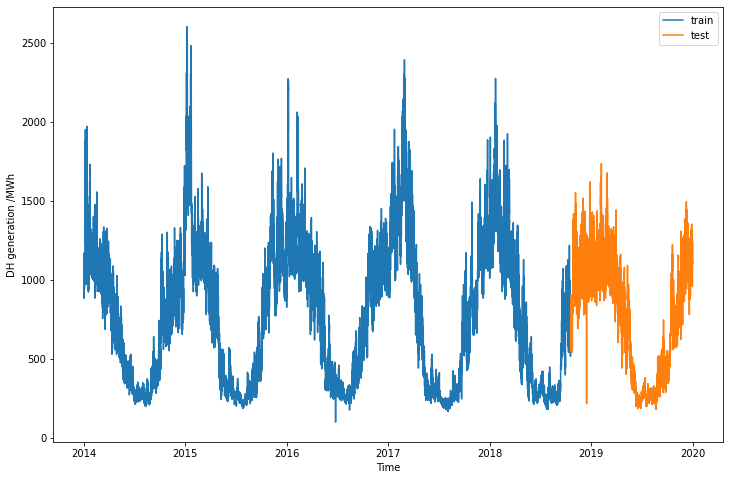

In [8]:
%matplotlib inline

fig = Figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(train.index, train['dh_MWh'], label='train')
ax.plot(test.index, test['dh_MWh'], label='test')

ax.set_xlabel("Time")
ax.set_ylabel("DH generation /MWh")
ax.legend()
fig

Test dataset does not contain as cold temperatures as the train dataset.
Let's plot these variables in a scatter plot

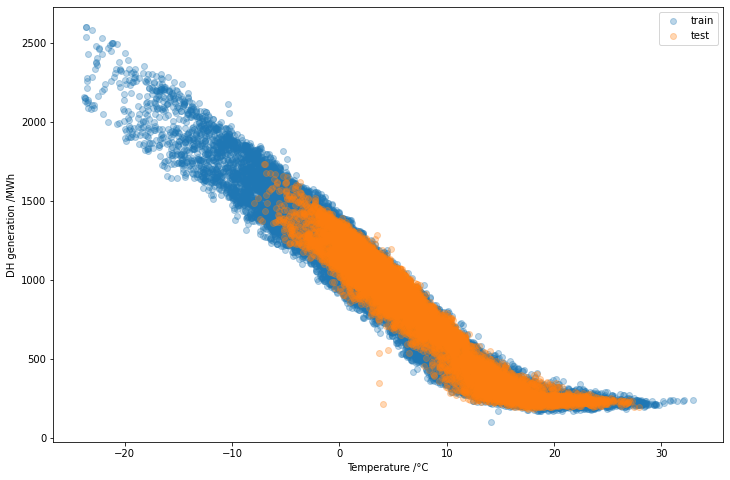

In [9]:
%matplotlib inline

fig = Figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(x=train['Ilman lämpötila (degC)'], y=train['dh_MWh'], label='train', alpha=0.3)
ax.scatter(x=test['Ilman lämpötila (degC)'], y=test['dh_MWh'], label='test', alpha=0.3)

ax.set_xlabel("Temperature /°C")
ax.set_ylabel("DH generation /MWh")
ax.legend()
fig

It very much seems that we can get a decent approximation for DH consumption from ambient temperature,
as a basis for a baseline model.

## Baseline model generation

Now we will generate a naive model, which acts as baseline when comparing other models

### Linear model from ambient temperature

In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(train[['Ilman lämpötila (degC)']], train['dh_MWh'])

temps = np.linspace(-22, 30)
preds = lm.predict(temps.reshape(-1, 1))

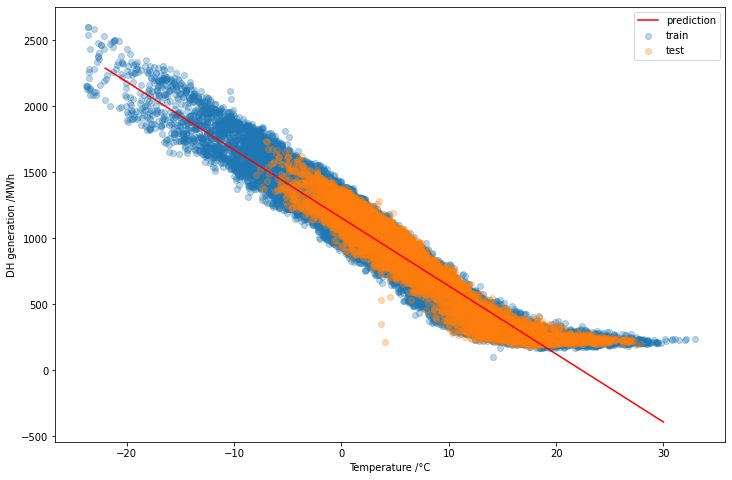

In [11]:
ax.plot(temps, preds, color='r', label='prediction')
ax.legend()
fig

In [12]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

all_pred = lm.predict(test[['Ilman lämpötila (degC)']])
metrics = dict()
metrics['mean_absolute_error'] = mean_absolute_error(test['dh_MWh'], all_pred)
metrics['mean_absolute_percentage_error'] = mean_absolute_percentage_error(test['dh_MWh'], all_pred)
metrics['root_mean_squared_error'] = mean_squared_error(test['dh_MWh'], all_pred, squared=False)
metrics

{'mean_absolute_error': 90.15714980707318,
 'mean_absolute_percentage_error': 0.17136669839757393,
 'root_mean_squared_error': 113.13444882577883}

We can see easily that a linear model fails to take into account base load and the temperature-dependent part.
Housing heat demand is usually removed at about 17 degrees, let's implement a piecewise linear model

### Piecewise linear model from ambient temperature

In [13]:
from dh_modelling.model import Model

??Model

Init signature: Model()
Docstring:      <no docstring>
Source:        
class Model:
    def __eq__(self, o: object) -> bool:
        if not isinstance(o, Model):
            return NotImplemented
        return self.params == o.params

    def fit(self, X: np.ndarray, y: np.ndarray):
        logging.info("Training model...")
        self.params, _ = optimize.curve_fit(self._piecewise_linear, X, y)

    def predict(self, X) -> np.ndarray:
        return self._piecewise_linear(X, *self.params)

    def _piecewise_linear(self, x, y0, k1) -> np.ndarray:
        x0 = 17
        k2 = 0
        return np.piecewise(
            x,
            [x < x0],
            [lambda x: k1 * x + y0 - k1 * x0, lambda x: k2 * x + y0 - k2 * x0],
        )
File:           c:\users\mikkokouhia\personal\helen-dh-generation-modelling\dh_modelling\model.py
Type:           type
Subclasses:     



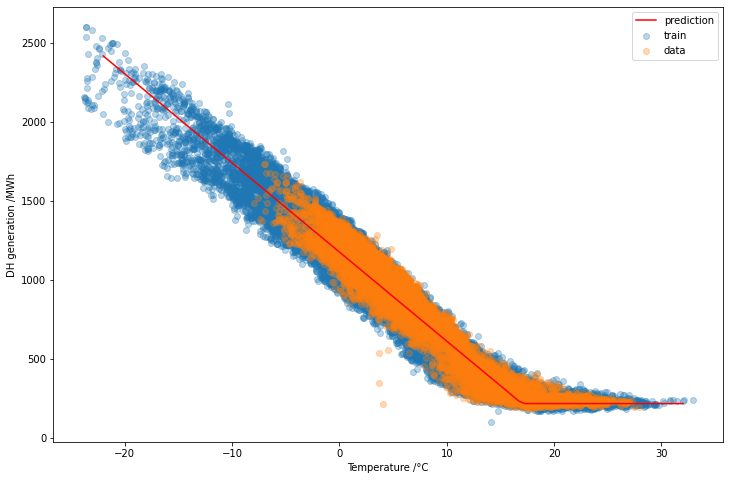

In [14]:
%matplotlib inline 

model: Model = Model()

X: np.ndarray = df["Ilman lämpötila (degC)"].to_numpy()
y: np.ndarray = df["dh_MWh"].to_numpy()

model.fit(X, y)

xd = np.linspace(-22, 32, 100)

fig2 = Figure(figsize=(12,8))
ax2 = fig2.add_subplot(111)
ax2.scatter(x=train['Ilman lämpötila (degC)'], y=train['dh_MWh'], label='train', alpha=0.3)
ax2.scatter(x=test['Ilman lämpötila (degC)'], y=test['dh_MWh'], label='data', alpha=0.3)
ax2.plot(xd, model.predict(xd), label= 'prediction', color='r')

ax2.set_xlabel("Temperature /°C")
ax2.set_ylabel("DH generation /MWh")
ax2.legend()
fig2

In [15]:
from dh_modelling.evaluate import evaluate

metrics: dict = evaluate(model, test)
metrics

{'mean_absolute_error': 75.87327152776903,
 'mean_absolute_percentage_error': 0.11427959301511317,
 'root_mean_squared_error': 94.62917541029597}

This will serve as our baseline model. Let's plot predictions and actual values for a sample period

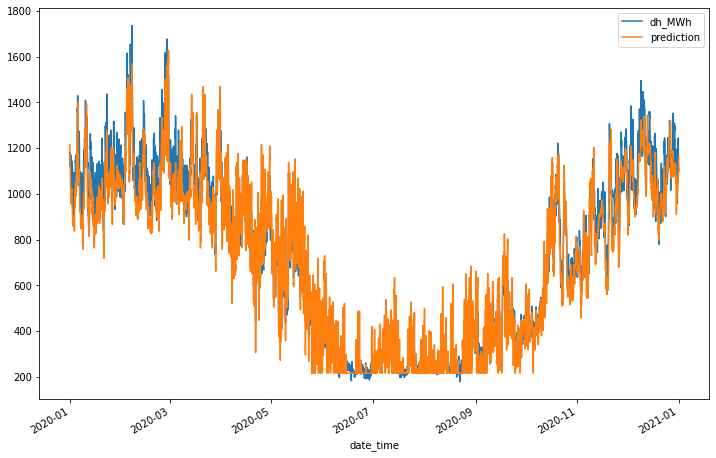

In [16]:
test['prediction'] = model.predict(test['Ilman lämpötila (degC)'].to_numpy())
fig3x = Figure(figsize=(12,8))
ax3x = fig3x.add_subplot(1,1,1)
test.loc[(test.index > '2020-01-01'), ['dh_MWh', 'prediction']].plot(ax=ax3x)

fig3x

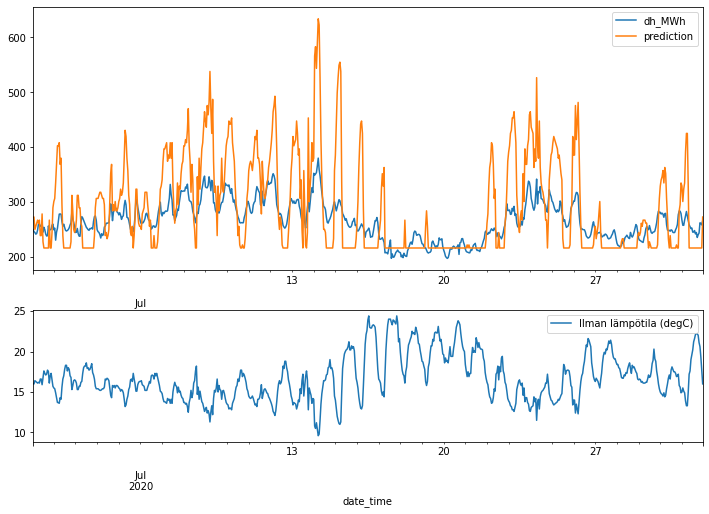

In [17]:
from matplotlib.gridspec import GridSpec

fig3 = Figure(figsize=(12,8))
spec = GridSpec(ncols=1, nrows=2, height_ratios=[2, 1])
ax31 = fig3.add_subplot(spec[0])
ax32 = fig3.add_subplot(spec[1])
test.loc[((test.index > '2020-07-01') & (test.index < '2020-08-01')), ['dh_MWh', 'prediction']].plot(ax=ax31)
test.loc[((test.index > '2020-07-01') & (test.index < '2020-08-01')), ['Ilman lämpötila (degC)']].plot(ax=ax32)

fig3

The PWL estimation overestimates the heat demand during summer months. Let's investigate the generation for a colder period.

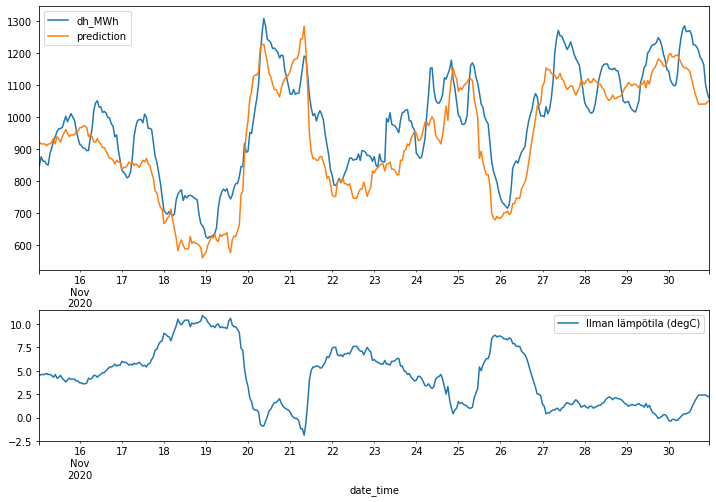

In [18]:
%matplotlib inline 

fig4 = Figure(figsize=(12,8))
spec = GridSpec(ncols=1, nrows=2, height_ratios=[2, 1])
ax41 = fig4.add_subplot(spec[0])
ax42 = fig4.add_subplot(spec[1])
test.loc[((test.index > '2020-11-15') & (test.index < '2020-12-01')), ['dh_MWh', 'prediction']].plot(ax=ax41)
test.loc[((test.index > '2020-11-15') & (test.index < '2020-12-01')), ['Ilman lämpötila (degC)']].plot(ax=ax42)

fig4

This is somewhat better. Later we will investigate other models against this baseline.